In [1]:
import os
import sys
import pathlib

module_path = os.path.abspath(os.path.join('../../'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import jax
import jax.numpy as jnp
import jax.random as rnd

import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from rationality import dynamics as dyn, objectives as obj, distributions as dst,\
    controllers as ctl, simulate as sim, util as util

Set up plotting configuration.

In [3]:
pathlib.Path('figures/').mkdir(parents=True, exist_ok=True)

fm._rebuild()
plt.style.reload_library()
plt.style.use(['science', 'notebook'])

%config InlineBackend.figure_format = 'svg'

figure_formats = ['png', 'eps', 'svg', 'pdf', 'pgf']


In [4]:
noise_variances = jnp.array([0.1, 0.1, 0.01, 0.01, 0.01, 0.01])

Control problem parameters.

In [5]:
horizon = 12
dt = 0.3  # try ~0.2

Q = jnp.eye(6)
R = 0.1 * jnp.eye(2)
Qf = 100 * jnp.eye(6)

ic = jnp.array([1.0, -1.0, 0.0, 0.0, 0.0, 0.0])
ic_cov = jnp.diag(jnp.array([1e-1, 1e-1, 1e-3, 1e-2, 1e-2, 1e-4]) ** 2)

The values of $\beta$ to sweep through.

In [6]:
inv_temps = jnp.exp(jnp.linspace(-4, 7, 50))

Create problem data structures.

In [7]:
objective = obj.quadratic(Q, R, Qf)
dynamics = dyn.crazyflie2d(dt)
linearized_dynamics = dyn.linear(*dyn.linearize(dynamics, jnp.zeros(6),
                                                jnp.array([dynamics.params.hover_force, 0.0]), 0))

prob = ctl.problem(linearized_dynamics, objective, horizon)

Compute the exact expected cost of the control problem.

In [8]:
lqr = ctl.lqr.create(prob)

print(f'Optimal Problem Value: {ctl.lqr.cost_to_go(prob, ic, ic_cov)}')

Optimal Problem Value: 6.3076629638671875


Setup the bounded-rationality controller and simulation.

In [9]:
noise_cov = jnp.transpose(jnp.tile(jnp.diag(jnp.array(noise_variances)), (horizon + 1, 1, 1)), (1, 2, 0))

key = rnd.PRNGKey(0)
key, subkey = rnd.split(key)

prior_params = ctl.lqr.input_stats(prob, ic, ic_cov)
prior_params = dst.GaussianParams(prior_params.mean, 10 * prior_params.cov)
lqbr = ctl.lqbr.create(prob, prior_params, 1.0, subkey)
lqbr_sim = sim.compile_simulation(prob, lqbr)

ctg_part_obs = jax.jit(
    lambda beta, scale: ctl.lqbr.cost_to_go(prob, ctl.lqbr.LQBRParams(beta, subkey, prior_params), ic, ic_cov,
                                     scale * noise_cov[:, :, :-1]))


Compute expected cost for different values of $\beta$ and $\sigma^2_{\hat{x}}$.

In [10]:
noise_coeffs = 0.25 * jnp.array([0.0, 1.0, 2.0, 3.0])

expected_problem_value = jax.vmap(lambda s: jax.vmap(lambda it: ctg_part_obs(it, s))(inv_temps), out_axes=-1)(noise_coeffs)
best_inv_temps = inv_temps[jnp.argmin(expected_problem_value, axis=0)]

Plot results:

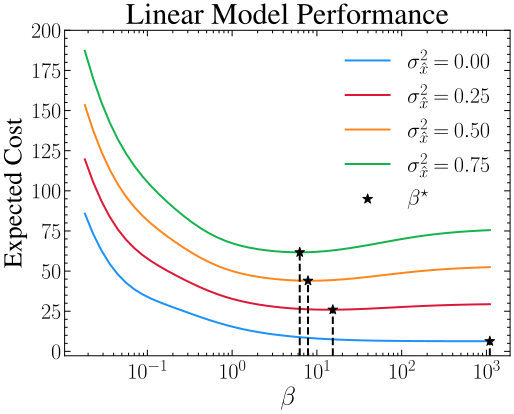

In [11]:
color_cycler = cycler.cycler(color=['#1E90FF', '#DC1839', '#FF871E', '#15B34E'])

# Weird bug in EPS file if I don't load then unload IEEE mode...
plt.style.use(['science', 'ieee', 'notebook'])
plt.style.use(['science', 'notebook'])

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='times')
plt.rc('axes', prop_cycle=color_cycler)
plt.rc('text.latex', preamble='\\usepackage{lmodern}\n\\renewcommand{\\rmdefault}{ptm}')

plt.figure()
plt.xscale('log')

for i, scale in enumerate(noise_coeffs):
    plt.plot(inv_temps, expected_problem_value[:, i], label=r'$\sigma^2_{\hat{x}}' + f' = {scale:.2f}$')

plt.ylim([plt.ylim()[0], 200])

for i, _ in enumerate(noise_coeffs):
    label = '$\\beta^\star$' if i == 0 else None
    plt.scatter(best_inv_temps[i], expected_problem_value[:, i].min(), s=100, c='k', marker='*', label=label, zorder=3)
    plt.vlines(best_inv_temps[i], ymin=plt.gca().get_ylim()[0], ymax=expected_problem_value[:, i].min(), colors='k', linestyles='--', zorder=3)

plt.legend(fontsize=22)
plt.title(r'\textrm{Linear Model Performance}', fontsize=30)
plt.ylabel(r'\textrm{Expected Cost}', fontsize=26)
plt.xlabel('$\\beta$', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

for tick in plt.gca().get_xaxis().get_major_ticks():
    tick.set_pad(8.0)

# util.savefig('figures/log-beta-expectation-analytic', figure_formats)

In [13]:
idx = 0
mean, cov = ctl.lqbr.state_distribution(prob, ctl.lqbr.LQBRParams(best_inv_temps[idx], subkey, prior_params), ic, ic_cov, noise_coeffs[idx] * noise_cov[:, :, :-1])

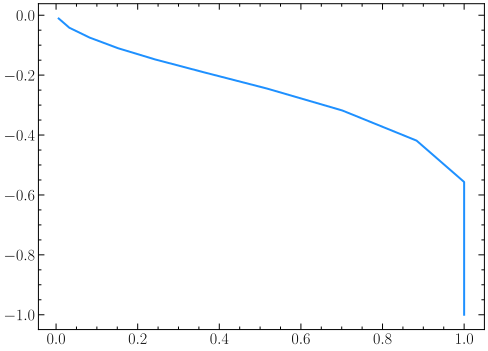

In [14]:
grid_spacing = 0.01
xs = jnp.arange(-0.25, 1.25, grid_spacing)
ys = jnp.arange(-0.25, 1.25, grid_spacing)

X, Y = jnp.meshgrid(xs, ys)